#### Config

In [1]:
import torch
from matplotlib.ticker import PercentFormatter, MaxNLocator
from checkpoint import model_from_checkpoint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from matplotlib.colors import LinearSegmentedColormap

_colors = ["#0d0887", "#7e03a8", "#cc4678", "#f89441", "#f0f921"]
my_cmap = LinearSegmentedColormap.from_list("mycmap", _colors, N=256)

#### Heatmap Helpers

##### Ungrouped

In [2]:

def plot_param_heatmaps(model, cols=6, cmap_count=my_cmap, cmap_bytes=my_cmap):
    items = []
    for name, t in model.state_dict().items():
        n = t.numel()
        nb = n * t.element_size()
        items.append((name, n, nb))

    # Sort consistently to keep positions aligned across both maps
    items.sort(key=lambda x: x[1], reverse=True)
    names = [x[0] for x in items]
    counts = np.array([x[1] for x in items], dtype=float)
    bytes_ = np.array([x[2] for x in items], dtype=float)

    total_counts = counts.sum() if counts.sum() > 0 else 1.0
    total_bytes = bytes_.sum() if bytes_.sum() > 0 else 1.0
    frac_counts = counts / total_counts
    frac_bytes = bytes_ / total_bytes

    n = len(items)
    rows = int(np.ceil(n / cols))
    size = rows * cols

    grid_counts = np.zeros(size, dtype=float)
    grid_bytes = np.zeros(size, dtype=float)
    grid_counts[:n] = frac_counts
    grid_bytes[:n] = frac_bytes
    grid_counts = grid_counts.reshape(rows, cols)
    grid_bytes = grid_bytes.reshape(rows, cols)

    fig, axes = plt.subplots(1, 2, figsize=(cols*1.4*2, max(1.6, rows*1.4)))
    # by count
    im1 = axes[0].imshow(grid_counts, cmap=cmap_count, aspect="auto")
    cbar1 = fig.colorbar(im1, ax=axes[0], label="Share of total params")
    cbar1.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))  # 0–100%
    cbar1.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max1 = grid_counts.max() if grid_counts.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < n:
                label = f"{names[idx]}\n{frac_counts[idx]*100:.1f}%"
                color = "white" if grid_counts[i, j] > (max1/3 if max1 else 0) else "black"
                axes[0].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_title("Parameter distribution (count)")

    # norm = colors.Normalize(vmin=0, vmax=0.2)
    #  gamma-like emphasis
    norm = colors.PowerNorm(gamma=0.5)                  # brighten small values
    # percentile-based clipping
    def pct_norm(a, lo=2, hi=98):
        vmin, vmax = np.percentile(a[a>0], [lo, hi]) if (a>0).any() else (0, 1)
        return colors.Normalize(vmin=vmin, vmax=vmax)

    # im = axes[0].imshow(grid_counts, cmap=cmap_count, norm=norm, aspect="auto")

    # by bytes
    im2 = axes[1].imshow(grid_bytes, cmap=cmap_bytes, aspect="auto", norm=norm)
    cbar2 = fig.colorbar(im2, ax=axes[1], label="Share of total bytes")
    cbar2.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar2.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))
    max2 = grid_bytes.max() if grid_bytes.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx < n:
                label = f"{names[idx].split('.')[-1]}\n{frac_bytes[idx]*100:.1f}%"
                color = "white" if grid_bytes[i, j] > (max2/3 if max2 else 0) else "black"
                axes[1].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[1].set_xticks([]); axes[1].set_yticks([])
    axes[1].set_title(f"Parameter distribution (bytes) ~ {total_bytes/1e6:.1f} MB")

    plt.tight_layout()
    plt.show()


##### Grouped

In [3]:
import re
from collections import defaultdict


def group_params_by_suffix(state_dict):
    pat = re.compile(r"^(?:blocks|value_embeds)\.(\d+)\.(.+)$")
    grouped = defaultdict(list)
    counts = defaultdict(int)
    bytes_ = defaultdict(int)

    for name, t in state_dict.items():
        m = pat.match(name)
        d_name = None
        if m:
            d_name = m.group(0)
            suffix = m.group(2)
            key = "value_embeds" if "value_embeds" in name else suffix
        else:
            key = name

        grouped[key].append((d_name , t))
        counts[key] += t.numel()
        bytes_[key] += t.numel() * t.element_size()

    return dict(grouped), dict(counts), dict(bytes_)

def plot_param_heatmaps_grouped(model, cols=6, cmap_count="viridis", cmap_bytes="magma"):
    grouped, counts_map, bytes_map = group_params_by_suffix(model.state_dict())

    # build items from grouped aggregates
    names = list(counts_map.keys())
    counts = np.array([counts_map[k] for k in names], dtype=float)
    bytes_ = np.array([bytes_map[k] for k in names], dtype=float)

    # sort by size to stabilize layout
    order = np.argsort(-counts)
    names = [names[i] for i in order]
    counts = counts[order]
    bytes_ = bytes_[order]

    total_counts = counts.sum() if counts.sum() > 0 else 1.0
    total_bytes = bytes_.sum() if bytes_.sum() > 0 else 1.0
    frac_counts = counts / total_counts
    frac_bytes = bytes_ / total_bytes

    n = len(names)
    rows = int(np.ceil(n / cols))
    size = rows * cols

    grid_counts = np.zeros(size, dtype=float)
    grid_bytes = np.zeros(size, dtype=float)
    grid_counts[:n] = frac_counts
    grid_bytes[:n] = frac_bytes
    grid_counts = grid_counts.reshape(rows, cols)
    grid_bytes = grid_bytes.reshape(rows, cols)

    fig, axes = plt.subplots(1, 2, figsize=(cols * 1.4 * 2, max(1.6, rows * 1.4)))
    im1 = axes[0].imshow(grid_counts, cmap=cmap_count, aspect="auto")
    cbar1 = fig.colorbar(im1, ax=axes[0], label="Share of total params")
    cbar1.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar1.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max1 = grid_counts.max() if grid_counts.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < n:
                label = f"{names[idx]}\n{frac_counts[idx] * 100:.1f}%"
                color = "white" if grid_counts[i, j] > (max1 / 3 if max1 else 0) else "black"
                axes[0].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title("Grouped parameter distribution (count)")

    from matplotlib import colors
    norm = colors.PowerNorm(gamma=0.5)
    im2 = axes[1].imshow(grid_bytes, cmap=cmap_bytes, aspect="auto", norm=norm)
    cbar2 = fig.colorbar(im2, ax=axes[1], label="Share of total bytes")
    cbar2.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    cbar2.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune=None))

    max2 = grid_bytes.max() if grid_bytes.size else 0
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < n:
                # shorten label by showing last 2 components when long
                parts = names[idx].split(".")
                short = ".".join(parts[-2:]) if len(parts) > 2 else names[idx]
                label = f"{short}\n{frac_bytes[idx] * 100:.1f}%"
                color = "white" if grid_bytes[i, j] > (max2 / 3 if max2 else 0) else "black"
                axes[1].text(j, i, label, ha="center", va="center", fontsize=7, color=color)
    axes[1].set_xticks([]);
    axes[1].set_yticks([])
    axes[1].set_title(f"Grouped parameter distribution (bytes) ~ {total_bytes / 1e6:.1f} MB")

    plt.tight_layout()
    plt.show()


### Stats

In [4]:
from checkpoint import model_from_checkpoint

path = "../checkpoints/20251103T2120-val5.780-step000101-run0-final.pt"


model, _ = model_from_checkpoint(path, device='mps')
model.eval()

DaisyCore(
  (embed): Embedding(50257, 512)
  (value_embeds): ModuleList(
    (0-2): 3 x Embedding(50257, 512)
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (attn): CausalSelfAttention(
        (rotary): Rotary()
      )
      (mlp): MLP()
    )
  )
)

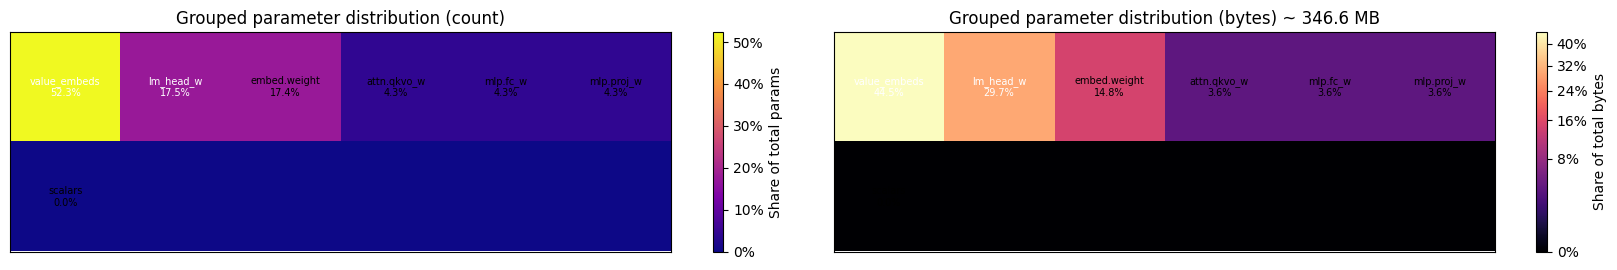

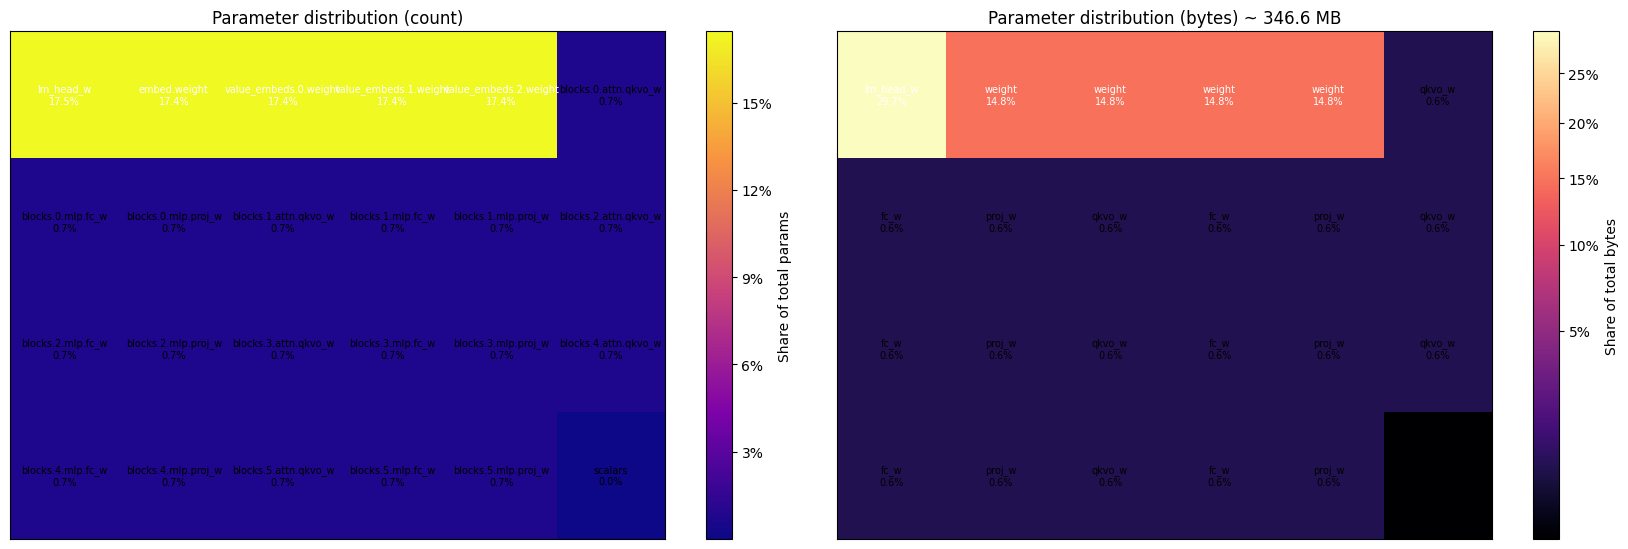

In [5]:
plot_param_heatmaps_grouped(model, cmap_count=my_cmap, cmap_bytes="magma")

plot_param_heatmaps(model, cmap_count=my_cmap, cmap_bytes="magma")

#### Details

In [6]:
from model_report import build_report, format_report_text

report = build_report(model)
print(format_report_text(report))

=== Checkpoint ===

=== Model stats ===
parameters (total): 147,556,382 (147556382)
parameters (trainable): 147,556,382 (147556382)
parameter size: 330.57 MiB
model type: DaisyCore
layers: 6

parameter dtypes:
  float32: 25,755,678 (25755678)
  bfloat16: 121,800,704 (121800704)

=== Learned scalars (DaisyCore) ===
num_layers (inferred): 6
threshold for near-zero: 0.001
- skip_weights: shape=[6], min=1, max=1.221, mean=1.037, std=0.08236
  near-zero: 0 elements (0.00%)
- lambdas: shape=[6, 2], min=0.213, max=1.374, mean=0.7711, std=0.4932
  near-zero: 0 elements (0.00%)
- sa_lambdas: shape=[6, 2], min=0.0252, max=0.273, mean=0.1502, std=0.07298
  near-zero: 0 elements (0.00%)

Per-layer (i: skip | lambda -> sa_lambda):
  00: 1.0000 | [1.3738, 0.3738] -> [0.0752, 0.0252]
  01: 1.0000 | [1.3322, 0.3293] -> [0.0957, 0.0736]
  02: 1.2210 | [1.2896, 0.2879] -> [0.1597, 0.1009]
  03: 1.0000 | [1.2204, 0.2589] -> [0.2287, 0.1657]
  04: 1.0000 | [1.1951, 0.2326] -> [0.2326, 0.1708]
  05: 1.0000

In [7]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total params: {total_params:,}")
for p in model.state_dict().items():
    print(f"[name] {p[0]},\t\t [shape] {list(p[1].shape)},\t [dtype] {str(p[1].dtype)[6:]},\t [numel] {p[1].numel()},\t [%total] {p[1].numel()/total_params*100:.2f}%")

Total params: 147,556,382
[name] lm_head_w,		 [shape] [50304, 512],	 [dtype] float32,	 [numel] 25755648,	 [%total] 17.45%
[name] scalars,		 [shape] [30],	 [dtype] float32,	 [numel] 30,	 [%total] 0.00%
[name] embed.weight,		 [shape] [50257, 512],	 [dtype] bfloat16,	 [numel] 25731584,	 [%total] 17.44%
[name] value_embeds.0.weight,		 [shape] [50257, 512],	 [dtype] bfloat16,	 [numel] 25731584,	 [%total] 17.44%
[name] value_embeds.1.weight,		 [shape] [50257, 512],	 [dtype] bfloat16,	 [numel] 25731584,	 [%total] 17.44%
[name] value_embeds.2.weight,		 [shape] [50257, 512],	 [dtype] bfloat16,	 [numel] 25731584,	 [%total] 17.44%
[name] blocks.0.attn.qkvo_w,		 [shape] [4, 512, 512],	 [dtype] bfloat16,	 [numel] 1048576,	 [%total] 0.71%
[name] blocks.0.mlp.fc_w,		 [shape] [2048, 512],	 [dtype] bfloat16,	 [numel] 1048576,	 [%total] 0.71%
[name] blocks.0.mlp.proj_w,		 [shape] [512, 2048],	 [dtype] bfloat16,	 [numel] 1048576,	 [%total] 0.71%
[name] blocks.1.attn.qkvo_w,		 [shape] [4, 512, 512],	 [dty

#### Sanity Check

In [8]:
import torch, zipfile, os

def inspect_sd(sd):
    by_dtype = {}
    total_bytes = 0
    for k, v in sd.items():
        print(k,v.dtype,v.shape)
        if isinstance(v, torch.Tensor):
            nbytes = v.untyped_storage().nbytes()
            total_bytes += nbytes
            by_dtype.setdefault(str(v.dtype), 0)
            by_dtype[str(v.dtype)] += nbytes
    print("bytes by dtype:", {k: f"{v/1024**2:.2f} MiB" for k,v in by_dtype.items()})
    print("sum(storage nbytes):", f"{total_bytes/1024**2:.2f} MiB\n")


with zipfile.ZipFile(path, "r") as z:
    stored = [i.file_size for i in z.infolist() if '/data/' in i.filename]
print("sum(zip data/*):", f"{sum(stored)/1024**2:.2f} MiB", "entries:", len(stored))

from checkpoint import model_from_checkpoint


pt_sd = torch.load(path, weights_only=True, mmap=True)['model']
pt_model, hparams = model_from_checkpoint(path, device='mps')

inspect_sd(pt_sd) # directly from torch
inspect_sd(pt_model.state_dict()) # through app code


sum(zip data/*): 330.57 MiB entries: 24
lm_head_w torch.float32 torch.Size([50304, 512])
scalars torch.float32 torch.Size([30])
embed.weight torch.bfloat16 torch.Size([50257, 512])
value_embeds.0.weight torch.bfloat16 torch.Size([50257, 512])
value_embeds.1.weight torch.bfloat16 torch.Size([50257, 512])
value_embeds.2.weight torch.bfloat16 torch.Size([50257, 512])
blocks.0.attn.qkvo_w torch.bfloat16 torch.Size([4, 512, 512])
blocks.0.mlp.fc_w torch.bfloat16 torch.Size([2048, 512])
blocks.0.mlp.proj_w torch.bfloat16 torch.Size([512, 2048])
blocks.1.attn.qkvo_w torch.bfloat16 torch.Size([4, 512, 512])
blocks.1.mlp.fc_w torch.bfloat16 torch.Size([2048, 512])
blocks.1.mlp.proj_w torch.bfloat16 torch.Size([512, 2048])
blocks.2.attn.qkvo_w torch.bfloat16 torch.Size([4, 512, 512])
blocks.2.mlp.fc_w torch.bfloat16 torch.Size([2048, 512])
blocks.2.mlp.proj_w torch.bfloat16 torch.Size([512, 2048])
blocks.3.attn.qkvo_w torch.bfloat16 torch.Size([4, 512, 512])
blocks.3.mlp.fc_w torch.bfloat16 torc

In [9]:
import torch

sd = model.state_dict()
def storage_key(t):
    s = t.untyped_storage()
    return (s.data_ptr(), s.nbytes())

groups = {}
for k, v in sd.items():
    if isinstance(v, torch.Tensor):
        groups.setdefault(storage_key(v), []).append(k)

print("## Shared Storage:")
for k, names in groups.items():
    if len(names) > 1:
        print(names)

print("\n## Unique Storage:")
for k, names in groups.items():
    if len(names) == 1:
        print(names)

## Shared Storage:

## Unique Storage:
['lm_head_w']
['scalars']
['embed.weight']
['value_embeds.0.weight']
['value_embeds.1.weight']
['value_embeds.2.weight']
['blocks.0.attn.qkvo_w']
['blocks.0.mlp.fc_w']
['blocks.0.mlp.proj_w']
['blocks.1.attn.qkvo_w']
['blocks.1.mlp.fc_w']
['blocks.1.mlp.proj_w']
['blocks.2.attn.qkvo_w']
['blocks.2.mlp.fc_w']
['blocks.2.mlp.proj_w']
['blocks.3.attn.qkvo_w']
['blocks.3.mlp.fc_w']
['blocks.3.mlp.proj_w']
['blocks.4.attn.qkvo_w']
['blocks.4.mlp.fc_w']
['blocks.4.mlp.proj_w']
['blocks.5.attn.qkvo_w']
['blocks.5.mlp.fc_w']
['blocks.5.mlp.proj_w']
